# Support Vector Machine (SVM)
## _Modelo: Epsilon-Support Vector Regressor (ε-SVM Regression)_

El objetivo es intentar predecir el 'track_popularity' de cualquier canción.

Para ello probaermos distintas configuraciones de modelos SVR entrenados con distintas versiones del dataset:
- Datos escalados,
- PCA de 6 componentes (sólo *musical features*),
- PCA de 9 componentes *(incluye dummies de 'genre').*


In [20]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (mean_absolute_error, r2_score,
                             root_mean_squared_error, 
                             mean_absolute_percentage_error)

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


In [12]:
df = pd.read_csv('datasets/df_scaled.csv')
df_pca = pd.read_csv('datasets/df_pca6.csv')

# PCA 6 componentes

## Preparación

In [6]:
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23081 entries, 0 to 23080
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PC0               23081 non-null  float64
 1   PC1               23081 non-null  float64
 2   PC2               23081 non-null  float64
 3   PC3               23081 non-null  float64
 4   PC4               23081 non-null  float64
 5   PC5               23081 non-null  float64
 6   track_id          23081 non-null  object 
 7   track_popularity  23081 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.4+ MB


In [4]:
y = df_pca['track_popularity']
X = df_pca.drop(columns=['track_popularity','track_id'])

Separamos el dataset en sets de entrenamiento y testeo.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Entrenamiento

Realizamos una búsqueda de los mejores parámetros de Support Vector Regressor para nuestro dataset.

In [50]:
# Se crea el modelo SVR
svm_hitters = SVR()

### Grid Search

**Tiempo de ejecución: 20h** (Interrumpido sin resultados)

In [10]:
"""
grid = GridSearchCV(svm_hitters,
                    [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]},
                     {"C": [0.01, 1, 100], "gamma": [0.1, 1, 10, 100], "kernel": ["rbf", "sigmoid"]},
                     {"C": [0.01, 1, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}],
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error') 
grid.fit(X_train,y_train)
"""

'\ngrid = GridSearchCV(svm_hitters,\n                    [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]},\n                     {"C": [0.01, 1, 100], "gamma": [0.1, 1, 10, 100], "kernel": ["rbf", "sigmoid"]},\n                     {"C": [0.01, 1, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}],\n                    refit=True,\n                    cv=5,\n                    scoring=\'neg_mean_absolute_error\') \ngrid.fit(X_train,y_train)\n'

Se decide procesar por separado cada kernel y disminuir la cantidad de hiperparámetros sobre los que realizar la búsqueda para optimizar el uso de recursos.

### Linear

**Tiempo de ejecución 1: 15m 12.5s**

{'C': 0.01, 'kernel': 'linear'}

**Tiempo de ejecución 2: 16m 0s**

{'C': 5, 'kernel': 'linear'}

In [11]:
param_grid_linear = [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]}]

grid_linear = GridSearchCV(svm_hitters,
                           param_grid_linear,
                           refit=True,
                           verbose=1,
                           cv=5,
                           n_jobs=-1,
                           scoring='neg_mean_absolute_error')

grid_linear.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10, 100],
                          'kernel': ['linear']}],
             scoring='neg_mean_absolute_error', verbose=1)

Se agrega 'verbose' para tener más información durante el entrenamiento de los modelos.

In [12]:
grid_linear.best_params_

{'C': 5, 'kernel': 'linear'}

### Rbf / Sigmoid

**Tiempo de ejecución 1: 14m 10s**

{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}

**Tiempo de ejecución 2: 15m 53s**

{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}

In [14]:
param_grid_rbf_sigmoid = [{"C": [0.01, 1, 100], "gamma": [0.1, 1, 10, 100], "kernel": ["rbf", "sigmoid"]}]

grid_rbf_sigmoid = GridSearchCV(svm_hitters,
                                param_grid_rbf_sigmoid,
                                refit=True,
                                verbose=2,
                                cv=5,
                                n_jobs=-1,
                                scoring='neg_mean_absolute_error')

grid_rbf_sigmoid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=  12.7s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=  12.7s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=  12.8s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=  12.8s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=  12.8s
[CV] END ..................C=0.01, gamma=0.1, kernel=sigmoid; total time=  16.8s
[CV] END ..................C=0.01, gamma=0.1, kernel=sigmoid; total time=  17.0s
[CV] END ..................C=0.01, gamma=0.1, kernel=sigmoid; total time=  17.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  13.5s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  13.6s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=  13.6s
[CV] END ..................C=0.01, gamma=0.1, kernel=sigmoid; total time=  17.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.01, 1, 100], 'gamma': [0.1, 1, 10, 100],
                          'kernel': ['rbf', 'sigmoid']}],
             scoring='neg_mean_absolute_error', verbose=2)

In [15]:
grid_rbf_sigmoid.best_params_

{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}

**Tiempo de ejecución: 7h 20m** (Interrumpido sin resultados)

In [ ]:
"""
param_grid_poly = [{"C": [0.01, 1, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}]

grid_poly = GridSearchCV(svm_hitters,
                    param_grid_poly,
                    refit=True,
                    cv=5,
                    n_jobs=-1,
                    scoring='neg_mean_absolute_error')

grid_poly.fit(X_train,y_train)
"""

Se decide cambiar el algoritmo de búsqueda de 'GridSearchCV' a una búsqueda en 2 etapas:
1. RandomSearchCV -> Búsqueda general
2. BayesSearch CV -> Búsqueda fina

Esto se hace con el fin de hacer una búsqueda más eficiente, evitando recorrer todos los polinomios complejos (degree alto) en caso de no ser necesario.

### Randomized Search + Bayesian Search _(Poly)_

#### RandomizedSearchCV

**Tiempo de ejecución: 6h 10m** 

Mejores parámetros iniciales (kernel 'poly'): {'degree': 2, 'C': 0.01}

In [29]:
# Definir el modelo inicial: SVR con kernel 'poly'
model_poly = SVR(kernel='poly')

# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist_poly = {
    "C": [0.01, 1, 100],
    "degree": [2, 3, 4, 5, 6]
}

# Realizar RandomizedSearchCV
random_search_poly = RandomizedSearchCV(
    estimator=model_poly,
    param_distributions=param_dist_poly,
    n_iter=10,
    cv=3,
    verbose=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)


print('Comienza RandomizedSearchCV …')
random_search_poly.fit(X_train, y_train)
print('RandomizedSearchCV finalizado.')

# Imprimir los mejores parámetros obtenidos
print(f"Mejores parámetros iniciales (kernel 'poly'): {random_search_poly.best_params_}")

# Obtener los mejores parámetros del RandomizedSearchCV
best_C = random_search_poly.best_params_['C']
best_degree = random_search_poly.best_params_['degree']

Comienza RandomizedSearchCV …
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END .................C=0.01, degree=2;, score=-0.160 total time=   6.7s
[CV 2/3] END .................C=0.01, degree=2;, score=-0.162 total time=   6.7s
[CV 3/3] END .................C=0.01, degree=2;, score=-0.159 total time=   6.4s
[CV 3/3] END ....................C=1, degree=6;, score=-0.166 total time= 4.7min
[CV 1/3] END ....................C=1, degree=6;, score=-0.169 total time= 4.8min
[CV 2/3] END ....................C=1, degree=6;, score=-0.171 total time= 4.8min
[CV 1/3] END ....................C=1, degree=2;, score=-0.160 total time=   9.4s
[CV 2/3] END ....................C=1, degree=2;, score=-0.162 total time=   9.4s
[CV 3/3] END ....................C=1, degree=2;, score=-0.159 total time=   9.8s
[CV 2/3] END ....................C=1, degree=5;, score=-0.165 total time= 1.5min
[CV 1/3] END ....................C=1, degree=5;, score=-0.163 total time= 1.9min
[CV 1/3] END .....

#### BayesSearchCV

**Tiempo de ejecución: 3m 25s** 

Mejores parámetros refinados (kernel 'poly'): OrderedDict({'C': 0.013203785556797243, 'degree': 2, 'kernel': 'poly'})


In [24]:
# Definir el espacio de búsqueda refinado para BayesSearchCV
param_dist_poly = {
    'C': Real(max(0.01, best_C * 0.5), best_C * 2, prior='log-uniform'),
    'degree': Integer(max(2, best_degree - 1), min(6, best_degree + 1)),
    'kernel': ['poly']
}

# Usar BayesSearchCV para búsqueda fina
bayes_search_poly = BayesSearchCV(
    estimator=SVR(kernel='poly'),
    search_spaces=param_dist_poly,
    n_iter=30,
    cv=5,
    verbose=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print('Comienza BayesSearchCV …')
bayes_search_poly.fit(X_train, y_train)
print('BayesSearchCV finalizado.')

# Imprimir los mejores parámetros refinados
print(f"Mejores parámetros refinados (kernel 'poly'): {bayes_search_poly.best_params_}")

Comienza BayesSearchCV …
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=0.013287815610330047, degree=3, kernel=poly;, score=-0.161 total time=   6.7s
[CV 2/5] END C=0.013287815610330047, degree=3, kernel=poly;, score=-0.161 total time=   6.7s
[CV 5/5] END C=0.013287815610330047, degree=3, kernel=poly;, score=-0.160 total time=   6.6s
[CV 3/5] END C=0.013287815610330047, degree=3, kernel=poly;, score=-0.163 total time=   6.7s
[CV 4/5] END C=0.013287815610330047, degree=3, kernel=poly;, score=-0.159 total time=   6.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END C=0.017868126276991084, degree=3, kernel=poly;, score=-0.163 total time=   6.0s
[CV 5/5] END C=0.017868126276991084, degree=3, kernel=poly;, score=-0.160 total time=   6.0s
[CV 4/5] END C=0.017868126276991084, degree=3, kernel=poly;, score=-0.159 total time=   6.1s
[CV 1/5] END C=0.017868126276991084, degree=3, kernel=poly;, score=-0.161 total time=   5.4s
[CV 2/5] END C=0.017

## Análisis de Resultados

In [25]:
best_params_linear = grid_linear.best_params_
best_score_linear = grid_linear.best_score_

best_params_rbf_sigmoid = grid_rbf_sigmoid.best_params_
best_score_rbf_sigmoid = grid_rbf_sigmoid.best_score_

In [35]:
# Crear un diccionario para almacenar los resultados de cada búsqueda
results = {}

# Para el kernel 'linear'
results_linear = pd.DataFrame(grid_linear.cv_results_)
results_linear['kernel'] = 'linear'  # Añadimos una columna para identificar el kernel
results['linear'] = results_linear

# Para los kernels 'rbf' y 'sigmoid'
results_rbf_sigmoid = pd.DataFrame(grid_rbf_sigmoid.cv_results_)
results_rbf_sigmoid['kernel'] = 'rbf_sigmoid'  # Añadimos una columna para identificar el kernel
# Los kernels 'rbf' y 'sigmoid' ya están especificados en 'param_kernel'
results['rbf_sigmoid'] = results_rbf_sigmoid

# Para el kernel 'poly'
results_poly_rnd = pd.DataFrame(random_search_poly.cv_results_)
results_poly_rnd['kernel'] = 'poly'
results['poly'] = results_poly_rnd

results_poly_bay = pd.DataFrame(bayes_search_poly.cv_results_)
results_poly_bay['kernel'] = 'poly'
results['poly'] = results_poly_bay

# Combinar todos los resultados en un solo DataFrame
all_results = pd.concat(results.values(), ignore_index=True)

In [36]:
all_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
0        7.614177      0.070521         1.118652        0.011127      0.01   
1        9.459782      0.346048         1.208647        0.133480       0.1   
2       27.237295      0.652843         1.424638        0.156228         1   
3       83.441741      2.483717         1.037893        0.041161         5   
4      130.787092      8.686166         1.031781        0.078469        10   
..            ...           ...              ...             ...       ...   
55       5.017172      0.053311         0.785352        0.020007  0.012849   
56       5.077163      0.058971         0.867946        0.017352  0.017443   
57       4.993726      0.012789         0.755816        0.007939  0.015403   
58       4.946245      0.015486         0.892497        0.004730  0.012536   
59       4.602185      0.038538         0.876362        0.009421   0.01943   

   param_kernel                                             params  \
0        linear                    {'C': 0.01, 'kernel': 'linear'}   
1        linear                     {'C': 0.1, 'kernel': 'linear'}   
2        linear                       {'C': 1, 'kernel': 'linear'}   
3        linear                       {'C': 5, 'kernel': 'linear'}   
4        linear                      {'C': 10, 'kernel': 'linear'}   
..          ...                                                ...   
55         poly  {'C': 0.012848917284402758, 'degree': 3, 'kern...   
56         poly  {'C': 0.01744270377126299, 'degree': 3, 'kerne...   
57         poly  {'C': 0.015402950166589598, 'degree': 2, 'kern...   
58         poly  {'C': 0.012535781609407224, 'degree': 2, 'kern...   
59         poly  {'C': 0.01943036728783988, 'degree': 2, 'kerne...   

    split0_test_score  split1_test_score  split2_test_score  \
0           -0.160226          -0.160086          -0.162268   
1           -0.160226          -0.160087          -0.162271   
2           -0.160226          -0.160088          -0.162275   
3           -0.160225          -0.160083          -0.162271   
4           -0.160227          -0.160083          -0.162272   
..                ...                ...                ...   
55          -0.160575          -0.160653          -0.163168   
56          -0.160588          -0.160661          -0.163187   
57          -0.159878          -0.160463          -0.162719   
58          -0.159878          -0.160459          -0.162724   
59          -0.159868          -0.160465          -0.162714   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           -0.158646          -0.159227        -0.160091        0.001232   
1           -0.158641          -0.159237        -0.160092        0.001233   
2           -0.158644          -0.159230        -0.160093        0.001235   
3           -0.158647          -0.159224        -0.160090        0.001233   
4           -0.158646          -0.159232        -0.160092        0.001233   
..                ...                ...              ...             ...   
55          -0.159072          -0.159687        -0.160631        0.001397   
56          -0.159066          -0.159690        -0.160638        0.001405   
57          -0.158819          -0.159404        -0.160257        0.001345   
58          -0.158815          -0.159406        -0.160256        0.001347   
59          -0.158817          -0.159412        -0.160255        0.001343   

    rank_test_score  kernel param_gamma param_degree  
0                 2  linear         NaN          NaN  
1                 4  linear         NaN          NaN  
2                 5  linear         NaN          NaN  
3                 1  linear         NaN          NaN  
4                 3  linear         NaN          NaN  
..              ...     ...         ...          ...  
55               19    poly         NaN            3  
56               28    poly         NaN            3  
57               12    poly         NaN          

In [38]:
# Ahora, encontrar el mejor modelo basado en la puntuación media de validación cruzada
# Dado que estamos utilizando 'neg_mean_absolute_error', una puntuación más alta (menos negativa) es mejor
best_index = all_results['mean_test_score'].idxmax()
best_model = all_results.iloc[best_index]

print("Mejor modelo:")
print(best_model[['kernel', 'param_kernel', 'param_C', 'param_gamma', 'param_degree', 'mean_test_score']])

Mejor modelo:
kernel             rbf_sigmoid
param_kernel               rbf
param_C                   0.01
param_gamma                0.1
param_degree               NaN
mean_test_score      -0.159841
Name: 6, dtype: object


In [11]:
# Guardar los mejores parámetros de la búsqueda
best_model = grid_rbf_sigmoid.best_estimator_

# Exportación del modelo
if best_model is not None:
    model_save_path = "models/svr_pca6.pkl"
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Mejor modelo: {best_model}")
    print(f"Guardado como '{model_save_path}'")

Mejor modelo: SVR(C=0.01, gamma=0.1)
Guardado como 'models/svr_pca6.pkl'


In [39]:
#Si deseas ver todos los parámetros del mejor modelo
print("\nTodos los parámetros del mejor modelo:")
print(best_model)


Todos los parámetros del mejor modelo:
mean_fit_time                                          8.094525
std_fit_time                                           0.033116
mean_score_time                                        4.669354
std_score_time                                         0.039178
param_C                                                    0.01
param_kernel                                                rbf
params               {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
split0_test_score                                     -0.159965
split1_test_score                                     -0.160048
split2_test_score                                     -0.161677
split3_test_score                                     -0.158521
split4_test_score                                     -0.158992
mean_test_score                                       -0.159841
std_test_score                                         0.001085
rank_test_score                                               1


In [44]:
# Filtrar los resultados para el kernel 'poly'
poly_results = all_results[all_results['kernel'] == 'poly'].copy()

In [45]:
# Analizamos la mejor configuración para kernel polinomial
best_index_poly = poly_results['mean_test_score'].idxmax()
best_model_poly = poly_results.iloc[best_index]

print("Mejores parámestros para 'poly':")
print(best_model_poly[['kernel', 'param_kernel', 'param_C', 'param_gamma', 'param_degree', 'mean_test_score']])

Mejores parámestros para 'poly':
kernel                 poly
param_kernel           poly
param_C            0.015338
param_gamma             NaN
param_degree              3
mean_test_score   -0.160637
Name: 36, dtype: object


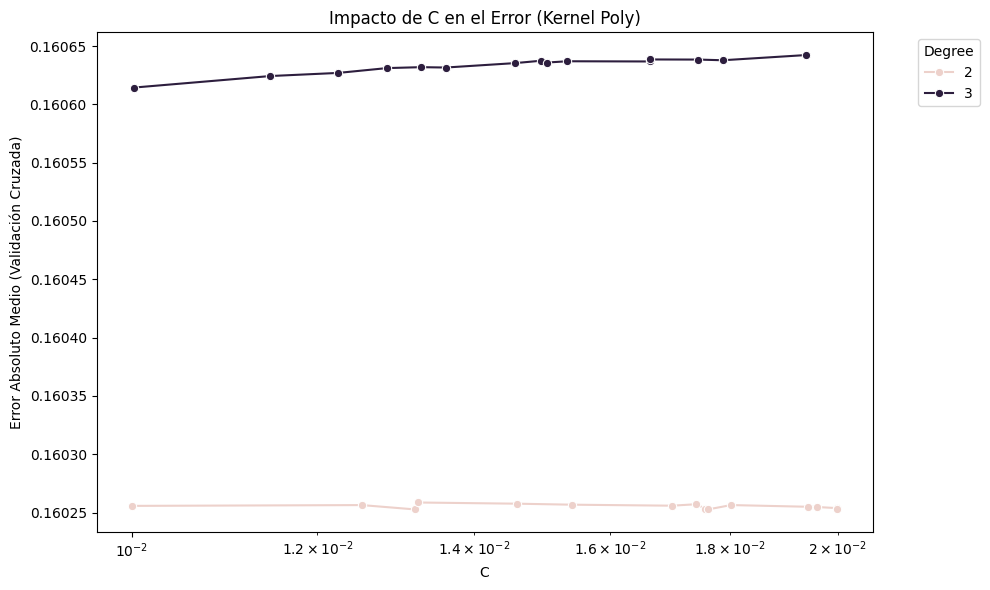

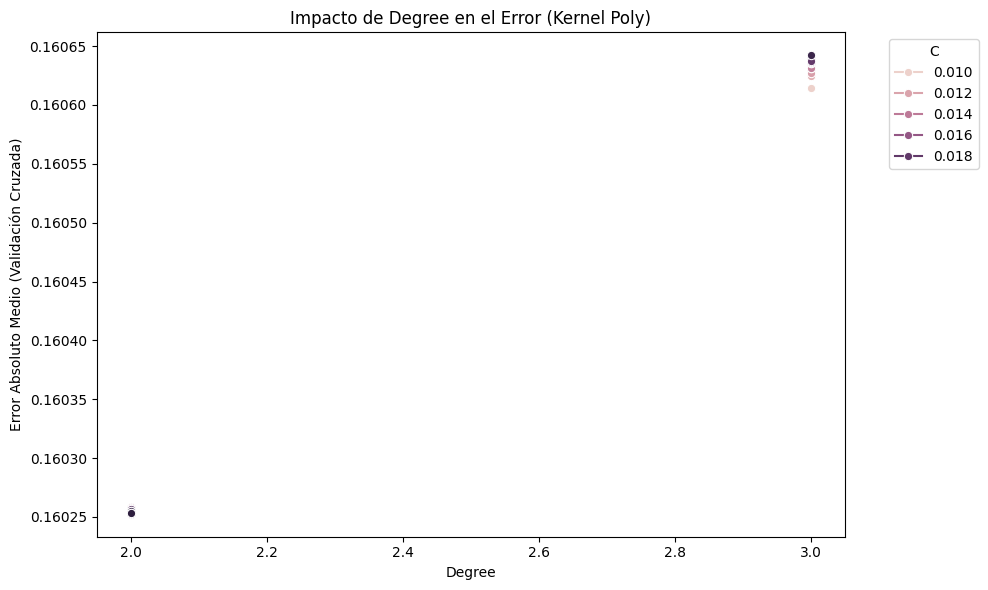

In [46]:
# Filtrar los resultados para el kernel 'poly'
poly_results = all_results[all_results['kernel'] == 'poly'].copy()

# Convertir los valores negativos de la puntuación a errores positivos
poly_results['mean_absolute_error'] = -poly_results['mean_test_score']

# Convertir 'param_C' y 'param_degree' a tipos numéricos si es necesario
poly_results['param_C'] = poly_results['param_C'].astype(float)
poly_results['param_degree'] = poly_results['param_degree'].astype(int)

# Gráfico 1: Error vs. C para diferentes valores de degree
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=poly_results,
    x='param_C',
    y='mean_absolute_error',
    hue='param_degree',
    marker='o'
)
plt.title('Impacto de C en el Error (Kernel Poly)')
plt.xlabel('C')
plt.ylabel('Error Absoluto Medio (Validación Cruzada)')
plt.xscale('log')  # Escala logarítmica si C varía en órdenes de magnitud
plt.legend(title='Degree', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gráfico 2: Error vs. Degree para diferentes valores de C
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=poly_results,
    x='param_degree',
    y='mean_absolute_error',
    hue='param_C',
    marker='o'
)
plt.title('Impacto de Degree en el Error (Kernel Poly)')
plt.xlabel('Degree')
plt.ylabel('Error Absoluto Medio (Validación Cruzada)')
plt.legend(title='C', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [64]:
all_results.to_csv('datasets/svr_results.csv', index=False)

## Comparación de Métricas

In [62]:
# Extraer los parámetros del mejor modelo
params = {}
params['kernel'] = best_model['param_kernel']
params['C'] = best_model['param_C']

# Algunos parámetros pueden ser NaN si no aplican al kernel seleccionado
if not pd.isna(best_model.get('param_gamma')):
    params['gamma'] = best_model['param_gamma']

if not pd.isna(best_model.get('param_degree')):
    params['degree'] = int(best_model['param_degree'])

# Crear y entrenar el modelo con los mejores parámetros
best_svr_model = SVR(**params)
best_svr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_svr_model.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.15994229831958814
RMSE de testeo fue: 0.1943452915874804
MAPE de testeo fue: 10542280272399.533
R2 de testeo fue: 0.010002396511244682


Comparación con el modelo polinomial

In [48]:
# Extraer los parámetros del mejor modelo
params = {}
params['kernel'] = best_model_poly['param_kernel']
params['C'] = best_model_poly['param_C']

# Algunos parámetros pueden ser NaN si no aplican al kernel seleccionado
if not pd.isna(best_model.get('param_gamma')):
    params['gamma'] = best_model['param_gamma']

if not pd.isna(best_model.get('param_degree')):
    params['degree'] = int(best_model['param_degree'])

# Crear y entrenar el modelo con los mejores parámetros
best_svr_model = SVR(**params)
best_svr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_svr_model.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.16051435912036538
RMSE de testeo fue: 0.19506423091136824
MAPE de testeo fue: 10604771296271.812
R2 de testeo fue: 0.002664274934974009


Entrenamos una regresión lineal de Ridge para comparar las métricas.

In [20]:
# Se crea un modelo Ridge
ridge_hitters = Ridge()

grid_ridge = GridSearchCV(ridge_hitters,
                    {"alpha": np.linspace(0, 20, 1000)},
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error')
grid_ridge.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 0.        ,  0.02002002,  0.04004004,  0.06006006,  0.08008008,
        0.1001001 ,  0.12012012,  0.14014014,  0.16016016,  0.18018018,
        0.2002002 ,  0.22022022,  0.24024024,  0.26026026,  0.28028028,
        0.3003003 ,  0.32032032,  0.34034034,  0.36036036,  0.38038038,
        0.4004004 ,  0.42042042,  0.44044044,  0.46046046,  0.48048048,
        0.5005005 ,  0.52052052,  0.5...
       19.41941942, 19.43943944, 19.45945946, 19.47947948, 19.4994995 ,
       19.51951952, 19.53953954, 19.55955956, 19.57957958, 19.5995996 ,
       19.61961962, 19.63963964, 19.65965966, 19.67967968, 19.6996997 ,
       19.71971972, 19.73973974, 19.75975976, 19.77977978, 19.7997998 ,
       19.81981982, 19.83983984, 19.85985986, 19.87987988, 19.8998999 ,
       19.91991992, 19.93993994, 19.95995996, 19.97997998, 20.        ])},
             scoring='neg_mean_absolute_error')

In [21]:
grid_ridge.best_params_

{'alpha': 0.0}

In [24]:
ridge_hitters = grid_ridge.best_estimator_

y_pred = ridge_hitters.predict(X_test)
y_pred_ridge = y_pred

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.16069644864677907
RMSE de testeo fue: 0.1946560227523725
MAPE de testeo fue: 10382514201157.889
R2 de testeo fue: 0.006834128019646002


# Scaled dataset

## Preparación

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23081 entries, 0 to 23080
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          23081 non-null  object 
 1   track_popularity  23081 non-null  float64
 2   danceability      23081 non-null  float64
 3   energy            23081 non-null  float64
 4   loudness          23081 non-null  float64
 5   mode              23081 non-null  int64  
 6   speechiness       23081 non-null  float64
 7   acousticness      23081 non-null  float64
 8   instrumentalness  23081 non-null  float64
 9   liveness          23081 non-null  float64
 10  valence           23081 non-null  float64
 11  tempo             23081 non-null  float64
 12  duration_ms       23081 non-null  float64
 13  year              23081 non-null  float64
 14  genre_edm         23081 non-null  bool   
 15  genre_latin       23081 non-null  bool   
 16  genre_pop         23081 non-null  bool  

In [66]:
y = df['track_popularity']
X = df.drop(columns=['track_popularity','track_id'])

Separamos el dataset en sets de entrenamiento y testeo.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Entrenamiento

Realizamos una búsqueda de los mejores parámetros de Support Vector Regressor para nuestro dataset.

In [60]:
# Se crea el modelo SVR
svm_hitters = SVR()

### Grid Search (linear)

**Tiempo de ejecución: 2m 42s**

{'C': 10, 'kernel': 'linear'}

In [54]:
param_lin_scaled = [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]}]

grid_lin_scaled = GridSearchCV(svm_hitters,
                           param_lin_scaled,
                           refit=True,
                           verbose=3,
                           cv=5,
                           n_jobs=-1,
                           scoring='neg_mean_absolute_error')

grid_lin_scaled.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 4/5] END ............C=0.01, kernel=linear;, score=-0.157 total time=   8.3s
[CV 3/5] END ............C=0.01, kernel=linear;, score=-0.152 total time=   8.4s
[CV 1/5] END ............C=0.01, kernel=linear;, score=-0.155 total time=   8.4s
[CV 2/5] END ............C=0.01, kernel=linear;, score=-0.156 total time=   8.4s
[CV 5/5] END ............C=0.01, kernel=linear;, score=-0.150 total time=   8.6s
[CV 2/5] END .............C=0.1, kernel=linear;, score=-0.155 total time=   9.0s
[CV 1/5] END .............C=0.1, kernel=linear;, score=-0.155 total time=   9.1s
[CV 3/5] END .............C=0.1, kernel=linear;, score=-0.151 total time=   9.1s
[CV 4/5] END .............C=0.1, kernel=linear;, score=-0.157 total time=   9.9s
[CV 5/5] END .............C=0.1, kernel=linear;, score=-0.150 total time=   9.9s
[CV 2/5] END ...............C=1, kernel=linear;, score=-0.155 total time=  12.0s
[CV 1/5] END ...............C=1, kernel=linear;, 

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10, 100],
                          'kernel': ['linear']}],
             scoring='neg_mean_absolute_error', verbose=3)

In [61]:
grid_lin_scaled.best_params_

{'C': 10, 'kernel': 'linear'}

In [107]:
# Guardar los mejores parámetros de la búsqueda
best_model = grid_lin_scaled.best_estimator_ 

# Exportación del modelo
if best_model is not None:
    model_save_path = "models/svr_linear.pkl" 
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Mejor modelo: {best_model}")
    print(f"Guardado como '{model_save_path}'")

Mejor modelo: SVR(C=10, kernel='linear')
Guardado como 'models/svr_linear.pkl'


### Randomized Search + Bayesian Search (RBF)

#### RandomizedSearchCV

**Tiempo de ejecución 1: 3m 55s** 

Mejores parámetros iniciales (kernel 'rbf'): {'gamma': 0.1, 'C': 100}

**Tiempo de ejecución 2: 4m 14s** 

Mejores parámetros iniciales (kernel 'rbf'): {'gamma': 0.1, 'C': 100}

**Tiempo de ejecución 3: 3m 58s** 

Mejores parámetros iniciales (kernel 'rbf'): {'gamma': 0.1, 'C': 100}

In [68]:
# Definir el modelo inicial: SVR con kernel 'poly'
model_rbf = SVR(kernel='rbf')

# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist_rbf = {
    "C": [0.01, 1, 100],
    "gamma": [0.1, 1, 10, 100]
}

# Realizar RandomizedSearchCV
random_search_rbf = RandomizedSearchCV(
    estimator=model_rbf,
    param_distributions=param_dist_rbf,
    n_iter=20,
    cv=3,
    verbose=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)


print('Comienza RandomizedSearchCV …')
random_search_rbf.fit(X_train, y_train)
print('RandomizedSearchCV finalizado.')

# Imprimir los mejores parámetros obtenidos
print(f"Mejores parámetros iniciales (kernel 'rbf'): {random_search_rbf.best_params_}")

# Obtener los mejores parámetros del RandomizedSearchCV
best_C = random_search_rbf.best_params_['C']
best_gamma = random_search_rbf.best_params_['gamma']

Comienza RandomizedSearchCV …
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/miniconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END ..................C=0.01, gamma=1;, score=-0.152 total time=  15.0s
[CV 2/3] END ..................C=0.01, gamma=1;, score=-0.150 total time=  15.0s
[CV 3/3] END ..................C=0.01, gamma=1;, score=-0.150 total time=  15.0s
[CV 1/3] END .................C=0.01, gamma=10;, score=-0.156 total time=  15.2s
[CV 1/3] END ................C=0.01, gamma=0.1;, score=-0.156 total time=  15.4s
[CV 3/3] END ................C=0.01, gamma=0.1;, score=-0.153 total time=  15.4s
[CV 2/3] END .................C=0.01, gamma=10;, score=-0.154 total time=  15.3s
[CV 2/3] END ................C=0.01, gamma=0.1;, score=-0.153 total time=  15.5s
[CV 3/3] END .................C=0.01, gamma=10;, score=-0.154 total time=  15.0s
[CV 1/3] END ...................C=1, gamma=0.1;, score=-0.151 total time=  14.9s
[CV 2/3] END ...................C=1, gamma=0.1;, score=-0.148 total time=  15.0s
[CV 3/3] END ...................C=1, gamma=0.1;, score=-0.148 total time=  15.1s
[CV 1/3] END ...............

#### BayesSearchCV

**Tiempo de ejecución 1: 49m 20s** 

Mejores parámetros refinados (kernel rbf): {'C': 50.808090296938666, 'gamma': 0.07691862572278974, 'kernel': 'rbf'}

**Tiempo de ejecución 2: 39m 50s** 

Mejores parámetros refinados (kernel rbf): {'C': 50.808090296938666, 'gamma': 0.07691862572278974, 'kernel': 'rbf'}

In [77]:
# Definir el espacio de búsqueda refinado para BayesSearchCV
param_dist_rbf = {
    'C': Real(max(0.01, best_C * 0.5), best_C * 2, prior='log-uniform'),
    'gamma': Real(1e-6, 1e1, prior='log-uniform'),  # Búsqueda en un rango amplio de gamma
    'kernel': Categorical(['rbf'])
}

# Usar BayesSearchCV para búsqueda fina
bayes_search_rbf = BayesSearchCV(
    estimator=SVR(kernel='rbf'),
    search_spaces=param_dist_rbf,
    n_iter=30,
    cv=5,
    verbose=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print('Comienza BayesSearchCV …')
bayes_search_rbf.fit(X_train, y_train)
print('BayesSearchCV finalizado.')

# Imprimir los mejores parámetros refinados
print(f"Mejores parámetros refinados (kernel rbf): {bayes_search_rbf.best_params_}")


Comienza BayesSearchCV …
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END C=88.28302184706543, gamma=0.1241881627783703, kernel=rbf;, score=-0.146 total time=  29.1s
[CV 2/5] END C=88.28302184706543, gamma=0.1241881627783703, kernel=rbf;, score=-0.148 total time=  29.4s
[CV 4/5] END C=88.28302184706543, gamma=0.1241881627783703, kernel=rbf;, score=-0.150 total time=  29.8s
[CV 3/5] END C=88.28302184706543, gamma=0.1241881627783703, kernel=rbf;, score=-0.147 total time=  29.9s
[CV 1/5] END C=88.28302184706543, gamma=0.1241881627783703, kernel=rbf;, score=-0.148 total time=  30.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END C=159.63496832524962, gamma=1.5247791391944723, kernel=rbf;, score=-0.198 total time= 9.6min
[CV 1/5] END C=159.63496832524962, gamma=1.5247791391944723, kernel=rbf;, score=-0.198 total time=10.1min
[CV 5/5] END C=159.63496832524962, gamma=1.5247791391944723, kernel=rbf;, score=-0.196 total time=10.2min
[CV 3/5] END C

In [78]:
# Guardar los mejores parámetros de la búsqueda
best_model = bayes_search_rbf.best_estimator_

# Exportación del modelo
if best_model is not None:
    model_save_path = "models/svr_rbf.pkl"
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Mejor modelo: {best_model}")
    print(f"Guardado como '{model_save_path}'")

Mejor modelo: SVR(C=50.808090296938666, gamma=0.07691862572278974)
Guardado como 'models/svr_rbf.pkl'


### Randomized Search (Poly)

#### Búsqueda hasta polinomio de grado 4

**Tiempo de ejecución 1: 23m**

Mejores parámetros iniciales (kernel 'poly') hasta degree 4: {'degree': 3, 'C': 1}

In [79]:
# Definir el modelo inicial: SVR con kernel 'poly'
model_poly_low = SVR(kernel='poly')

# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist_poly_low = {
    "C": [0.01, 1, 100],
    "degree": [2, 3, 4]
}

# Realizar RandomizedSearchCV
random_search_poly_low = RandomizedSearchCV(
    estimator=model_poly_low,
    param_distributions=param_dist_poly_low,
    n_iter=20,
    cv=3,
    verbose=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)


print('Comienza RandomizedSearchCV …')
random_search_poly_low.fit(X_train, y_train)
print('RandomizedSearchCV finalizado.')

# Imprimir los mejores parámetros obtenidos
print(f"Mejores parámetros iniciales (kernel 'poly') hasta degree 4: {random_search_poly_low.best_params_}")

Comienza RandomizedSearchCV …
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/opt/miniconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END .................C=0.01, degree=2;, score=-0.153 total time=   6.6s
[CV 3/3] END .................C=0.01, degree=2;, score=-0.150 total time=   6.6s
[CV 2/3] END .................C=0.01, degree=2;, score=-0.150 total time=   6.6s
[CV 3/3] END .................C=0.01, degree=3;, score=-0.149 total time=   6.5s
[CV 1/3] END .................C=0.01, degree=3;, score=-0.152 total time=   6.6s
[CV 2/3] END .................C=0.01, degree=3;, score=-0.149 total time=   6.6s
[CV 1/3] END .................C=0.01, degree=4;, score=-0.151 total time=   6.7s
[CV 2/3] END .................C=0.01, degree=4;, score=-0.148 total time=   6.7s
[CV 3/3] END .................C=0.01, degree=4;, score=-0.148 total time=   7.2s
[CV 1/3] END ....................C=1, degree=2;, score=-0.151 total time=   8.9s
[CV 3/3] END ....................C=1, degree=2;, score=-0.149 total time=   9.2s
[CV 2/3] END ....................C=1, degree=2;, score=-0.148 total time=   9.2s
[CV 2/3] END ...............

#### Búsqueda polinomios de grado 5 y 6

**Tiempo de ejecución: 14m**

Mejores parámetros iniciales (kernel 'poly') degree mayor: {'degree': 5, 'C': 0.01}

In [80]:
# Definir el modelo inicial: SVR con kernel 'poly'
model_poly_high = SVR(kernel='poly')

# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist_poly_high = {
    "C": [0.01, 1, 10],
    "degree": [5, 6]
}

# Realizar RandomizedSearchCV
random_search_poly_high = RandomizedSearchCV(
    estimator=model_poly_high,
    param_distributions=param_dist_poly_high,
    n_iter=10,
    cv=3,
    verbose=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)


print('Comienza RandomizedSearchCV …')
random_search_poly_high.fit(X_train, y_train)
print('RandomizedSearchCV finalizado.')

# Imprimir los mejores parámetros obtenidos
print(f"Mejores parámetros iniciales (kernel 'poly') hasta degree mayor: {random_search_poly_high.best_params_}")

Comienza RandomizedSearchCV …
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/miniconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END .................C=0.01, degree=5;, score=-0.151 total time=   7.6s
[CV 3/3] END .................C=0.01, degree=5;, score=-0.148 total time=   7.6s
[CV 2/3] END .................C=0.01, degree=5;, score=-0.147 total time=   7.6s
[CV 3/3] END .................C=0.01, degree=6;, score=-0.148 total time=   9.3s
[CV 2/3] END .................C=0.01, degree=6;, score=-0.148 total time=   9.3s
[CV 1/3] END .................C=0.01, degree=6;, score=-0.150 total time=   9.3s
[CV 2/3] END ....................C=1, degree=5;, score=-0.152 total time=  44.7s
[CV 1/3] END ....................C=1, degree=5;, score=-0.153 total time=  47.7s
[CV 3/3] END ....................C=1, degree=5;, score=-0.152 total time=  46.0s
[CV 2/3] END ....................C=1, degree=6;, score=-0.157 total time= 1.6min
[CV 1/3] END ....................C=1, degree=6;, score=-0.157 total time= 1.7min
[CV 3/3] END ....................C=1, degree=6;, score=-0.156 total time= 1.7min
[CV 2/3] END ...............

#### Búsuqeda del mejor modelo polinomial

In [104]:
best_params_poly_high = random_search_poly_high.best_params_
best_score_poly_high = random_search_poly_high.best_score_

best_params_poly_low = random_search_poly_low.best_params_
best_score_poly_low = random_search_poly_low.best_score_

if best_score_poly_high > best_score_poly_low:
    print(f"Mejor modelo polinomial: {best_params_poly_high}")
    best_model = random_search_poly_high.best_estimator_ 
elif best_score_poly_high < best_score_poly_low:
    print(f"Mejor modelo polinomial: {best_params_poly_low}")
    best_model = random_search_poly_low.best_estimator_ 
else:
    print('Ambos modelos polinomiales tinene el mismo score.\nSe utilizará el polinomio de menor grado:{best_params_poly_low}')
    best_model = random_search_poly_low.best_estimator_ 

Mejor modelo polinomial: {'degree': 3, 'C': 1}


In [106]:
# Exportación del modelo
if best_model is not None:
    model_save_path = "models/svr_poly.pkl"
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Mejor modelo: {best_model}")
    print(f"Guardado como '{model_save_path}'")

Mejor modelo: SVR(C=1, kernel='poly')
Guardado como 'models/svr_poly.pkl'


## Análisis de Resultados

In [109]:
# Crear un diccionario para almacenar los resultados de cada búsqueda
results = {}

# Para el kernel 'linear'
results_lin_scaled = pd.DataFrame(grid_lin_scaled.cv_results_)
results_lin_scaled['kernel'] = 'linear'
results['linear'] = results_lin_scaled  # DataFrame stored

# Para el kernel 'rbf' con RandomSearch
results_rbf_rnd = pd.DataFrame(random_search_rbf.cv_results_)
results_rbf_rnd['kernel'] = 'rbf'
results['random'] = results_rbf_rnd  # Store DataFrame instead of search object

# Para el kernel 'rbf' con BayesSearch
results_rbf_bay = pd.DataFrame(bayes_search_rbf.cv_results_)
results_rbf_bay['kernel'] = 'rbf'
results['bayes'] = results_rbf_bay  # Store DataFrame instead of search object


# Para el kernel 'poly'
results_ply_low = pd.DataFrame(random_search_poly_low.cv_results_)
results_ply_low['kernel'] = 'poly'
results['poly_low'] = results_ply_low  # Store DataFrame instead of search object

results_ply_hig = pd.DataFrame(random_search_poly_high.cv_results_)
results_ply_hig['kernel'] = 'poly'
results['poly_low'] = results_ply_hig  # Store DataFrame instead of search object

# Combinar todos los resultados en un solo DataFrame
all_results = pd.concat(results.values(), ignore_index=True)

In [110]:
all_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        7.210493      0.067584         1.215437        0.012548    0.01   
1        7.973787      0.330937         1.428837        0.090984     0.1   
2       10.807236      0.155118         1.403006        0.062296       1   
3       18.706206      0.289735         1.381771        0.089292       5   
4       25.395887      1.044673         1.354260        0.087804      10   
..            ...           ...              ...             ...     ...   
49       7.093162      0.043852         2.214924        0.005864    0.01   
50      43.915864      1.166969         2.226353        0.104523       1   
51      98.977303      4.552415         1.901520        0.153503       1   
52     345.186751      9.405635         1.596310        0.265912      10   
53     720.211414      8.522340         1.046524        0.083387      10   

   param_kernel                           params  split0_test_score  \
0        linear  {'C': 0.01, 'kernel': 'linear'}          -0.155457   
1        linear   {'C': 0.1, 'kernel': 'linear'}          -0.155424   
2        linear     {'C': 1, 'kernel': 'linear'}          -0.155411   
3        linear     {'C': 5, 'kernel': 'linear'}          -0.155401   
4        linear    {'C': 10, 'kernel': 'linear'}          -0.155404   
..          ...                              ...                ...   
49          NaN         {'degree': 6, 'C': 0.01}          -0.150195   
50          NaN            {'degree': 5, 'C': 1}          -0.153059   
51          NaN            {'degree': 6, 'C': 1}          -0.157482   
52          NaN           {'degree': 5, 'C': 10}          -0.161586   
53          NaN           {'degree': 6, 'C': 10}          -0.174325   

    split1_test_score  split2_test_score  split3_test_score  \
0           -0.155707          -0.151729          -0.156602   
1           -0.155489          -0.151381          -0.156552   
2           -0.155480          -0.151325          -0.156572   
3           -0.155480          -0.151334          -0.156572   
4           -0.155478          -0.151330          -0.156571   
..                ...                ...                ...   
49          -0.147537          -0.148276                NaN   
50          -0.152326          -0.152182                NaN   
51          -0.157044          -0.155869                NaN   
52          -0.161702          -0.160546                NaN   
53          -0.175003          -0.172989                NaN   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
0           -0.150353        -0.153970        0.002460                6   
1           -0.150147        -0.153799        0.002540                5   
2           -0.150144        -0.153786        0.002553                3   
3           -0.150141        -0.153786        0.002551                2   
4           -0.150136        -0.153784        0.002553                1   
..                ...              ...             ...              ...   
49                NaN        -0.148670        0.001120                2   
50                NaN        -0.152522        0.000384                3   
51                NaN        -0.156798        0.000681                4   
52                NaN        -0.161278        0.000520                5   
53                NaN        -0.174105        0.000837                6   

    kernel param_gamma param_degree  
0   linear         NaN          NaN  
1   linear         NaN          NaN  
2   linear         NaN          NaN  
3   linear         NaN          NaN  
4   linear         NaN          NaN  
..     ...         ...          ...  
49    poly         NaN            6  
50    poly         NaN            5  
51    poly         NaN            6  
52    poly         NaN            5  
53    poly         NaN            6  

[54 rows x 18 columns]

In [111]:
# Ahora, encontrar el mejor modelo basado en la puntuación media de validación cruzada
# Dado que estamos utilizando 'neg_mean_absolute_error', una puntuación más alta (menos negativa) es mejor
best_index = all_results['mean_test_score'].idxmax()
best_model = all_results.iloc[best_index]

print("Mejor modelo:")
print(best_model[['kernel', 'param_kernel', 'param_C', 'param_gamma', 'mean_test_score']])

Mejor modelo:
kernel                  rbf
param_kernel            rbf
param_C            50.80809
param_gamma        0.076919
mean_test_score   -0.147647
Name: 46, dtype: object


In [112]:
#Si deseas ver todos los parámetros del mejor modelo
print("\nTodos los parámetros del mejor modelo:")
print(best_model)


Todos los parámetros del mejor modelo:
mean_fit_time                                                13.859872
std_fit_time                                                   0.12412
mean_score_time                                               3.045626
std_score_time                                                 0.03492
param_C                                                       50.80809
param_kernel                                                       rbf
params               {'C': 50.808090296938666, 'gamma': 0.076918625...
split0_test_score                                            -0.148357
split1_test_score                                            -0.147882
split2_test_score                                            -0.146458
split3_test_score                                            -0.150357
split4_test_score                                             -0.14518
mean_test_score                                              -0.147647
std_test_score                       

/var/folders/83/9353kc_5517028y13dxby8y40000gn/T/ipykernel_5915/1733266731.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_results['param_C'] = all_results['param_C'].astype(float)
/var/folders/83/9353kc_5517028y13dxby8y40000gn/T/ipykernel_5915/1733266731.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_results['param_kernel'] = all_results['param_kernel'].astype(str)


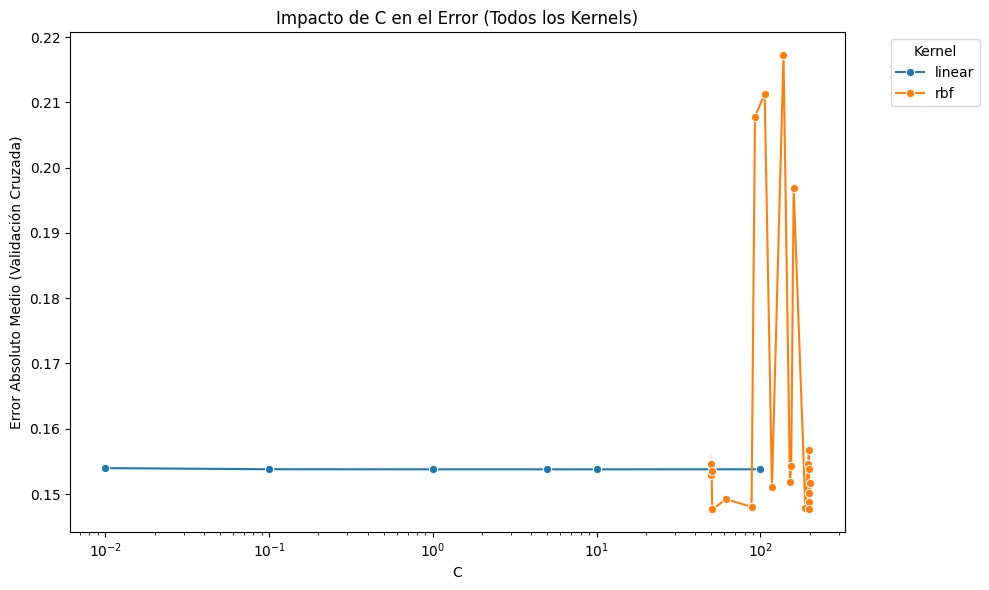

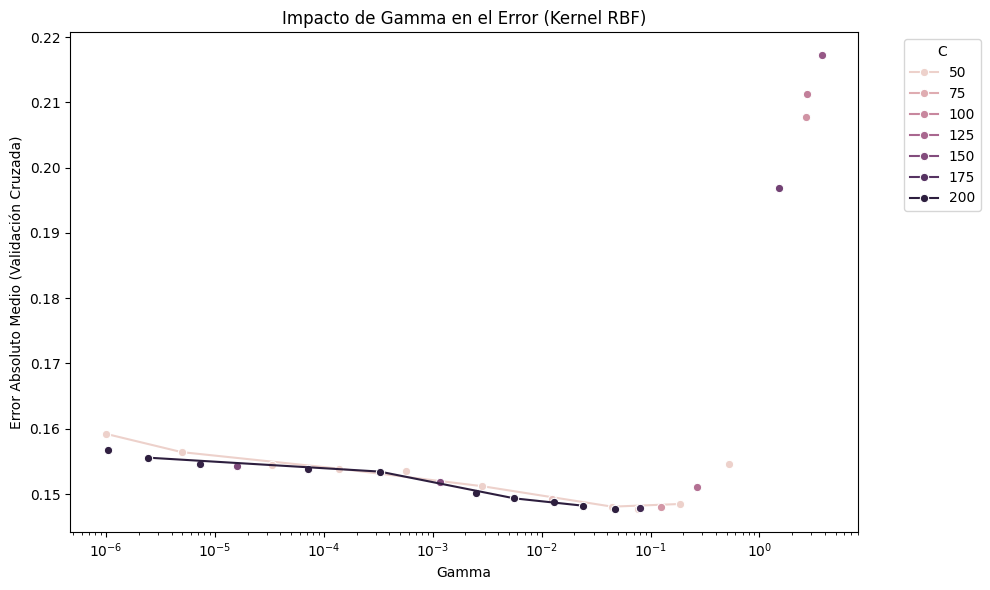

In [95]:
# Convertir los valores negativos de la puntuación a errores positivos
all_results['mean_absolute_error'] = -all_results['mean_test_score']

# Eliminar filas con valores NaN en 'mean_absolute_error', 'param_C' y 'param_kernel'
all_results = all_results.dropna(subset=['mean_absolute_error', 'param_C', 'param_kernel'])

# Convertir 'param_C' a tipo numérico si es necesario
all_results['param_C'] = all_results['param_C'].astype(float)

# Convertir 'param_kernel' a tipo string si es necesario
all_results['param_kernel'] = all_results['param_kernel'].astype(str)

# **Eliminar filas donde 'param_kernel' es la cadena 'nan'**
all_results = all_results[all_results['param_kernel'] != 'nan']

# Gráfico 1: Impacto de C en el Error para todos los kernels
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=all_results,
    x='param_C',
    y='mean_absolute_error',
    hue='param_kernel',
    marker='o'
)
plt.title('Impacto de C en el Error (Todos los Kernels)')
plt.xlabel('C')
plt.ylabel('Error Absoluto Medio (Validación Cruzada)')
plt.xscale('log')  # Escala logarítmica si C varía en órdenes de magnitud
plt.legend(title='Kernel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Filtrar resultados para el kernel 'rbf'
rbf_results = all_results[all_results['param_kernel'] == 'rbf'].copy()

# Eliminar filas con valores NaN en 'param_gamma' y 'mean_absolute_error'
rbf_results = rbf_results.dropna(subset=['param_gamma', 'mean_absolute_error', 'param_C'])

# Convertir 'param_gamma' y 'param_C' a tipo numérico si es necesario
rbf_results['param_gamma'] = rbf_results['param_gamma'].astype(float)
rbf_results['param_C'] = rbf_results['param_C'].astype(float)

# **Eliminar filas donde 'param_gamma' es la cadena 'nan'**
rbf_results = rbf_results[rbf_results['param_gamma'] != 'nan']

# Gráfico 2: Impacto de gamma en el Error para el kernel 'rbf'
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=rbf_results,
    x='param_gamma',
    y='mean_absolute_error',
    hue='param_C',
    marker='o'
)
plt.title('Impacto de Gamma en el Error (Kernel RBF)')
plt.xlabel('Gamma')
plt.ylabel('Error Absoluto Medio (Validación Cruzada)')
plt.xscale('log')  # Escala logarítmica si gamma varía en órdenes de magnitud
plt.legend(title='C', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Comparación de Métricas

In [96]:
# Extraer los parámetros del mejor modelo
params = {}
params['kernel'] = best_model['param_kernel']
params['C'] = best_model['param_C']
print(params)
print()

# Algunos parámetros pueden ser NaN si no aplican al kernel seleccionado
if not pd.isna(best_model.get('param_gamma')):
    params['gamma'] = best_model['param_gamma']

if not pd.isna(best_model.get('param_degree')):
    params['degree'] = int(best_model['param_degree'])

# Crear y entrenar el modelo con los mejores parámetros
best_svr_model = SVR(**params)
best_svr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_svr_model.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

{'kernel': 'rbf', 'C': 50.808090296938666}

MAE de testeo fue: 0.147476161226262
RMSE de testeo fue: 0.18346968752911408
MAPE de testeo fue: 10944384990528.627
R2 de testeo fue: 0.1337607354452981


Comparación con el modelo lineal

In [ ]:
# Use the best estimator from grid_lin_scaled
best_svr_model = grid_lin_scaled.best_estimator_

# Predict on the test set
y_pred = best_svr_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.15233886564799523
RMSE de testeo fue: 0.1867158607906215
MAPE de testeo fue: 11035514340356.107
R2 de testeo fue: 0.10283639973582581


Entrenamos una regresión lineal de Ridge para comparar las métricas.

In [89]:
# Se crea un modelo Ridge
ridge_hitters = Ridge()

grid_ridge = GridSearchCV(ridge_hitters,
                    {"alpha": np.linspace(0, 20, 1000)},
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error')
grid_ridge.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 0.        ,  0.02002002,  0.04004004,  0.06006006,  0.08008008,
        0.1001001 ,  0.12012012,  0.14014014,  0.16016016,  0.18018018,
        0.2002002 ,  0.22022022,  0.24024024,  0.26026026,  0.28028028,
        0.3003003 ,  0.32032032,  0.34034034,  0.36036036,  0.38038038,
        0.4004004 ,  0.42042042,  0.44044044,  0.46046046,  0.48048048,
        0.5005005 ,  0.52052052,  0.5...
       19.41941942, 19.43943944, 19.45945946, 19.47947948, 19.4994995 ,
       19.51951952, 19.53953954, 19.55955956, 19.57957958, 19.5995996 ,
       19.61961962, 19.63963964, 19.65965966, 19.67967968, 19.6996997 ,
       19.71971972, 19.73973974, 19.75975976, 19.77977978, 19.7997998 ,
       19.81981982, 19.83983984, 19.85985986, 19.87987988, 19.8998999 ,
       19.91991992, 19.93993994, 19.95995996, 19.97997998, 20.        ])},
             scoring='neg_mean_absolute_error')

In [90]:
grid_ridge.best_params_

{'alpha': 0.0}

In [91]:
ridge_hitters = grid_ridge.best_estimator_

y_pred = ridge_hitters.predict(X_test)
y_pred_ridge = y_pred

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.1528584508433987
RMSE de testeo fue: 0.18614300092165012
MAPE de testeo fue: 10824012387177.076
R2 de testeo fue: 0.10833310045571798


# PCA 9 componentes

In [13]:
df = pd.read_csv('datasets/df_pca9.csv')

## Preparación

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23081 entries, 0 to 23080
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PC0               23081 non-null  float64
 1   PC1               23081 non-null  float64
 2   PC2               23081 non-null  float64
 3   PC3               23081 non-null  float64
 4   PC4               23081 non-null  float64
 5   PC5               23081 non-null  float64
 6   PC6               23081 non-null  float64
 7   PC7               23081 non-null  float64
 8   PC8               23081 non-null  float64
 9   track_id          23081 non-null  object 
 10  track_popularity  23081 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


In [14]:
y = df['track_popularity']
X = df.drop(columns=['track_popularity','track_id'])

Separamos el dataset en sets de entrenamiento y testeo.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Entrenamiento

Realizamos una búsqueda de los mejores parámetros de Support Vector Regressor para nuestro dataset.

In [109]:
# Se crea el modelo SVR
svm_hitters = SVR()

### Grid Search (linear)

**Tiempo de ejecución: 36m 38s**

{'C': 100, 'kernel': 'linear'}

In [110]:
param_lin_scaled = [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]}]

grid_lin_scaled = GridSearchCV(svm_hitters,
                           param_lin_scaled,
                           refit=True,
                           verbose=3,
                           cv=5,
                           n_jobs=-1,
                           scoring='neg_mean_absolute_error')

grid_lin_scaled.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 3/5] END ............C=0.01, kernel=linear;, score=-0.161 total time=   9.6s
[CV 1/5] END ............C=0.01, kernel=linear;, score=-0.159 total time=   9.7s
[CV 5/5] END ............C=0.01, kernel=linear;, score=-0.158 total time=   9.7s
[CV 2/5] END ............C=0.01, kernel=linear;, score=-0.158 total time=   9.7s
[CV 4/5] END ............C=0.01, kernel=linear;, score=-0.157 total time=   9.7s
[CV 3/5] END .............C=0.1, kernel=linear;, score=-0.161 total time=  12.8s
[CV 1/5] END .............C=0.1, kernel=linear;, score=-0.159 total time=  12.9s
[CV 2/5] END .............C=0.1, kernel=linear;, score=-0.158 total time=  13.0s
[CV 5/5] END .............C=0.1, kernel=linear;, score=-0.158 total time=  13.3s
[CV 4/5] END .............C=0.1, kernel=linear;, score=-0.157 total time=  13.6s
[CV 3/5] END ...............C=1, kernel=linear;, score=-0.161 total time=  38.7s
[CV 2/5] END ...............C=1, kernel=linear;, 

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10, 100],
                          'kernel': ['linear']}],
             scoring='neg_mean_absolute_error', verbose=3)

In [111]:
grid_lin_scaled.best_params_

{'C': 100, 'kernel': 'linear'}

### Randomized Search + Bayesian Search (RBF)

#### RandomizedSearchCV

**Tiempo de ejecución: 3m 90s**

Mejores parámetros iniciales (kernel 'rbf'): {'gamma': 0.1, 'C': 0.01}

In [113]:
# Definir el modelo inicial: SVR con kernel 'poly'
model_rbf = SVR(kernel='rbf')

# Definir el espacio de búsqueda para RandomizedSearchCV
param_dist_rbf = {
    "C": [0.01, 1, 100],
    "gamma": [0.1, 1, 10, 100]
}

# Realizar RandomizedSearchCV
random_search_rbf = RandomizedSearchCV(
    estimator=model_rbf,
    param_distributions=param_dist_rbf,
    n_iter=20,
    cv=3,
    verbose=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)


print('Comienza RandomizedSearchCV …')
random_search_rbf.fit(X_train, y_train)
print('RandomizedSearchCV finalizado.')

# Imprimir los mejores parámetros obtenidos
print(f"Mejores parámetros iniciales (kernel 'rbf'): {random_search_rbf.best_params_}")

# Obtener los mejores parámetros del RandomizedSearchCV
best_C = random_search_rbf.best_params_['C']
best_gamma = random_search_rbf.best_params_['gamma']

Comienza RandomizedSearchCV …
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END ................C=0.01, gamma=0.1;, score=-0.159 total time=  13.1s
[CV 1/3] END ................C=0.01, gamma=0.1;, score=-0.158 total time=  13.2s
[CV 3/3] END ................C=0.01, gamma=0.1;, score=-0.157 total time=  15.1s
[CV 2/3] END ..................C=100, gamma=10;, score=-0.164 total time=  29.9s
[CV 1/3] END ..................C=100, gamma=10;, score=-0.163 total time=  30.1s
[CV 3/3] END ..................C=100, gamma=10;, score=-0.161 total time=  30.5s
[CV 1/3] END .....................C=1, gamma=1;, score=-0.174 total time=  25.1s
[CV 2/3] END .....................C=1, gamma=1;, score=-0.177 total time=  25.1s
[CV 1/3] END .................C=0.01, gamma=10;, score=-0.161 total time=  13.7s
[CV 2/3] END .................C=0.01, gamma=10;, score=-0.162 total time=  14.8s
[CV 3/3] END .....................C=1, gamma=1;, score=-0.172 total time=  29.1s
[CV 2/3] END .....

#### BayesSearchCV

**Tiempo de ejecución: 5m 6s** 

Mejores parámetros refinados (kernel rbf): OrderedDict({'C': 0.02, 'gamma': 0.04885540147784248, 'kernel': 'rbf'})

In [114]:
# Definir el espacio de búsqueda refinado para BayesSearchCV
param_dist_rbf = {
    'C': Real(max(0.01, best_C * 0.5), best_C * 2, prior='log-uniform'),
    'gamma': Real(1e-6, 1e1, prior='log-uniform'),  # Búsqueda en un rango amplio de gamma
    'kernel': Categorical(['rbf'])  # Kernel fijo a 'rbf'
}

# Usar BayesSearchCV para búsqueda fina
bayes_search_rbf = BayesSearchCV(
    estimator=SVR(kernel='rbf'),
    search_spaces=param_dist_rbf,
    n_iter=30,  # Más iteraciones para una búsqueda más exhaustiva
    cv=5,
    verbose=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

print('Comienza BayesSearchCV …')
bayes_search_rbf.fit(X_train, y_train)
print('BayesSearchCV finalizado.')

# Imprimir los mejores parámetros refinados
print(f"Mejores parámetros refinados (kernel rbf): {bayes_search_rbf.best_params_}")


Comienza BayesSearchCV …
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END C=0.013287815610330047, gamma=0.1241881627783703, kernel=rbf;, score=-0.157 total time=   7.8s
[CV 1/5] END C=0.013287815610330047, gamma=0.1241881627783703, kernel=rbf;, score=-0.158 total time=   7.9s
[CV 3/5] END C=0.013287815610330047, gamma=0.1241881627783703, kernel=rbf;, score=-0.159 total time=   7.9s
[CV 4/5] END C=0.013287815610330047, gamma=0.1241881627783703, kernel=rbf;, score=-0.157 total time=   7.9s
[CV 2/5] END C=0.013287815610330047, gamma=0.1241881627783703, kernel=rbf;, score=-0.158 total time=   8.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END C=0.017868126276991084, gamma=1.5247791391944723, kernel=rbf;, score=-0.158 total time=   7.9s
[CV 2/5] END C=0.017868126276991084, gamma=1.5247791391944723, kernel=rbf;, score=-0.159 total time=   8.0s
[CV 4/5] END C=0.017868126276991084, gamma=1.5247791391944723, kernel=rbf;, score=-0.158 total time= 

## Análisis de Resultados

In [116]:
# Crear un diccionario para almacenar los resultados de cada búsqueda
results = {}

# Para el kernel 'linear'
results_lin_scaled = pd.DataFrame(grid_lin_scaled.cv_results_)
results_lin_scaled['kernel'] = 'linear'
results['linear'] = results_lin_scaled  # DataFrame stored

# Para los kernels RandomSearch
results_rbf_rnd = pd.DataFrame(random_search_rbf.cv_results_)
results_rbf_rnd['kernel'] = 'rbf'
results['Random'] = results_rbf_rnd  # Store DataFrame instead of search object

# Para los kernels BayesSearch
results_rbf_bay = pd.DataFrame(bayes_search_rbf.cv_results_)
results_rbf_bay['kernel'] = 'rbf'
results['Bayes'] = results_rbf_bay  # Store DataFrame instead of search object

# Combinar todos los resultados en un solo DataFrame
all_results = pd.concat(results.values(), ignore_index=True)

In [117]:
all_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
0        8.424530      0.045047         1.268367        0.008473      0.01   
1       11.768642      0.322198         1.384867        0.051251       0.1   
2       37.920906      0.346607         1.210475        0.012191         1   
3      117.604147      5.710222         2.071967        0.516816         5   
4      197.940268      7.701690         1.434616        0.451182        10   
..            ...           ...              ...             ...       ...   
41       5.977462      0.048769         3.394618        0.010768  0.012849   
42       6.048029      0.017573         3.144846        0.027796  0.017443   
43       6.139847      0.052461         3.144525        0.016682  0.015403   
44       6.123513      0.041709         3.177562        0.024576  0.012536   
45       6.335059      0.041760         3.217349        0.026010   0.01943   

   param_kernel                                             params  \
0        linear                    {'C': 0.01, 'kernel': 'linear'}   
1        linear                     {'C': 0.1, 'kernel': 'linear'}   
2        linear                       {'C': 1, 'kernel': 'linear'}   
3        linear                       {'C': 5, 'kernel': 'linear'}   
4        linear                      {'C': 10, 'kernel': 'linear'}   
..          ...                                                ...   
41          rbf  {'C': 0.012848917284402758, 'gamma': 0.0438564...   
42          rbf  {'C': 0.01744270377126299, 'gamma': 0.03107901...   
43          rbf  {'C': 0.015402950166589598, 'gamma': 0.0001962...   
44          rbf  {'C': 0.012535781609407224, 'gamma': 0.0003254...   
45          rbf  {'C': 0.01943036728783988, 'gamma': 2.68070094...   

    split0_test_score  split1_test_score  split2_test_score  \
0           -0.158927          -0.158302          -0.160575   
1           -0.158926          -0.158299          -0.160569   
2           -0.158928          -0.158302          -0.160566   
3           -0.158926          -0.158300          -0.160572   
4           -0.158935          -0.158301          -0.160576   
..                ...                ...                ...   
41          -0.158261          -0.157671          -0.159403   
42          -0.158252          -0.157660          -0.159416   
43          -0.160223          -0.159636          -0.162561   
44          -0.160039          -0.159473          -0.162353   
45          -0.161045          -0.160424          -0.163478   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           -0.157456          -0.158145        -0.158681        0.001057   
1           -0.157462          -0.158140        -0.158679        0.001054   
2           -0.157463          -0.158137        -0.158679        0.001052   
3           -0.157460          -0.158142        -0.158680        0.001055   
4           -0.157456          -0.158140        -0.158682        0.001058   
..                ...                ...              ...             ...   
41          -0.156574          -0.157349        -0.157851        0.000948   
42          -0.156537          -0.157407        -0.157854        0.000956   
43          -0.158829          -0.159078        -0.160065        0.001337   
44          -0.158636          -0.158923        -0.159885        0.001324   
45          -0.159691          -0.159828        -0.160893        0.001379   

    rank_test_score  kernel param_gamma  
0                 5  linear         NaN  
1                 3  linear         NaN  
2                 2  linear         NaN  
3                 4  linear         NaN  
4                 6  linear         NaN  
..              ...     ...         ...  
41                7     rbf    0.043856  
42                8     rbf    0.031079  
43               20     rbf    0.000196  
44               19     rbf    0.000325  
45               29     rbf    0.000003  

[46 rows x 17 columns]

In [119]:
# Ahora, encontrar el mejor modelo basado en la puntuación media de validación cruzada
# Dado que estamos utilizando 'neg_mean_absolute_error', una puntuación más alta (menos negativa) es mejor
best_index = all_results['mean_test_score'].idxmax()
best_model = all_results.iloc[best_index]

print("Mejor modelo:")
print(best_model[['kernel', 'param_kernel', 'param_C', 'param_gamma', 'mean_test_score']])

Mejor modelo:
kernel                  rbf
param_kernel            rbf
param_C                0.02
param_gamma        0.048855
mean_test_score   -0.157797
Name: 29, dtype: object


In [19]:
# Guardar los mejores parámetros de la búsqueda
best_model = bayes_search_rbf.best_estimator_

# Exportación del modelo
if best_model is not None:
    model_save_path = "models/svr_pca9.pkl"
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Mejor modelo: {best_model}")
    print(f"Guardado como '{model_save_path}'")

Mejor modelo: SVR(C=0.02, gamma=0.048855)
Guardado como 'models/svr_pca9.pkl'


In [120]:
#Si deseas ver todos los parámetros del mejor modelo
print("\nTodos los parámetros del mejor modelo:")
print(best_model)


Todos los parámetros del mejor modelo:
mean_fit_time                                                 6.194691
std_fit_time                                                  0.043512
mean_score_time                                               3.515042
std_score_time                                                0.019561
param_C                                                           0.02
param_kernel                                                       rbf
params               {'C': 0.02, 'gamma': 0.04885540147784248, 'ker...
split0_test_score                                            -0.158257
split1_test_score                                            -0.157679
split2_test_score                                            -0.159204
split3_test_score                                            -0.156529
split4_test_score                                            -0.157319
mean_test_score                                              -0.157797
std_test_score                       

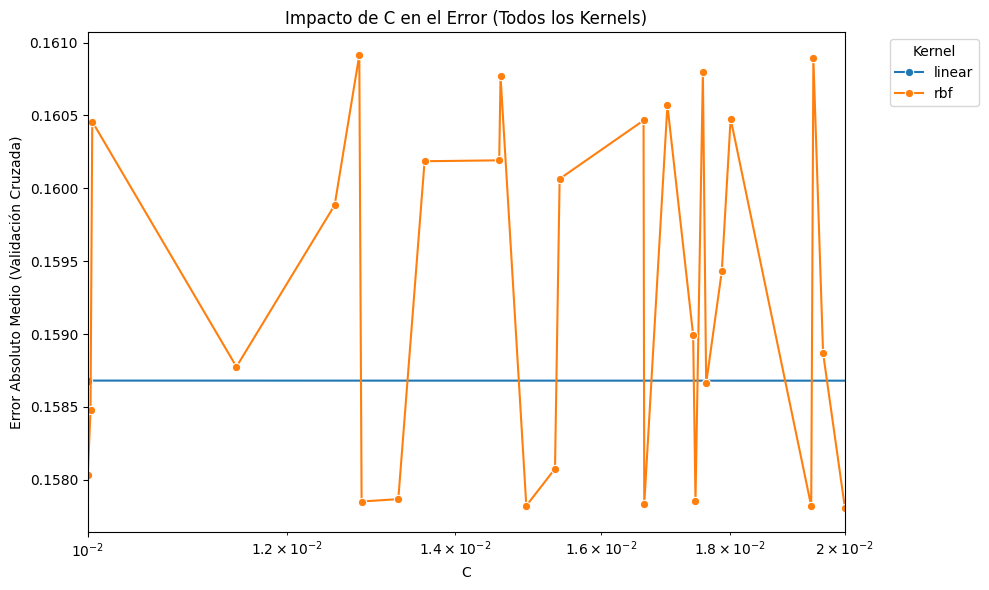

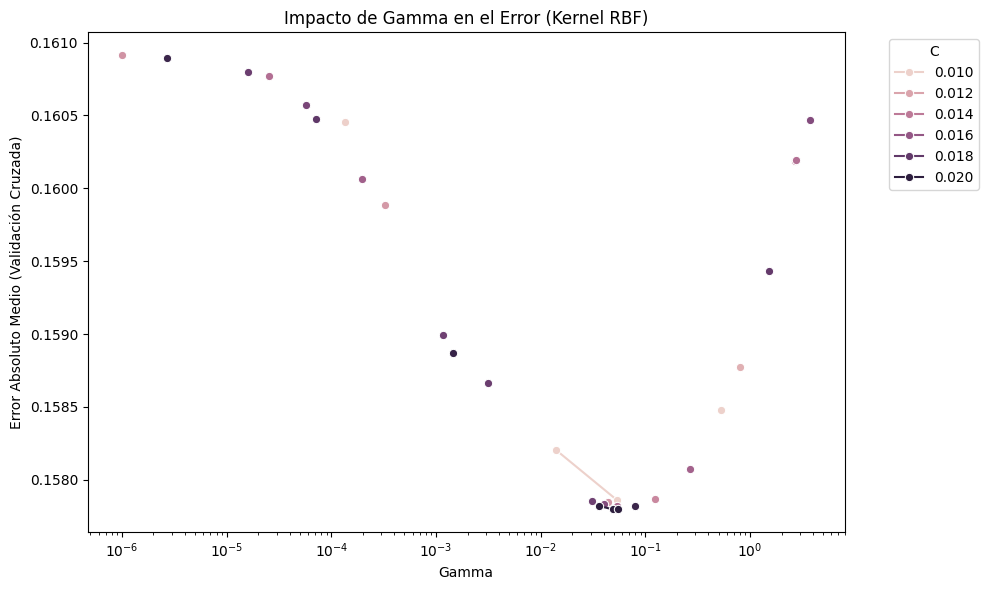

In [131]:
# Convertir los valores negativos de la puntuación a errores positivos
all_results['mean_absolute_error'] = -all_results['mean_test_score']

# Eliminar filas con valores NaN en 'mean_absolute_error', 'param_C' y 'param_kernel'
all_results = all_results.dropna(subset=['mean_absolute_error', 'param_C', 'param_kernel'])

# Convertir 'param_C' a tipo numérico si es necesario
all_results['param_C'] = all_results['param_C'].astype(float)

# Convertir 'param_kernel' a tipo string si es necesario
all_results['param_kernel'] = all_results['param_kernel'].astype(str)

# **Eliminar filas donde 'param_kernel' es la cadena 'nan'**
all_results = all_results[all_results['param_kernel'] != 'nan']

# Gráfico 1: Impacto de C en el Error para todos los kernels
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=all_results,
    x='param_C',
    y='mean_absolute_error',
    hue='param_kernel',
    marker='o'
)
plt.xlim(1e-2, 2e-2)  # Establece un rango desde 0.01 hasta 10 en el eje x
plt.title('Impacto de C en el Error (Todos los Kernels)')
plt.xlabel('C')
plt.ylabel('Error Absoluto Medio (Validación Cruzada)')
plt.xscale('log')  # Escala logarítmica si C varía en órdenes de magnitud
plt.legend(title='Kernel', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Filtrar resultados para el kernel 'rbf'
rbf_results = all_results[all_results['param_kernel'] == 'rbf'].copy()

# Eliminar filas con valores NaN en 'param_gamma' y 'mean_absolute_error'
rbf_results = rbf_results.dropna(subset=['param_gamma', 'mean_absolute_error', 'param_C'])

# Convertir 'param_gamma' y 'param_C' a tipo numérico si es necesario
rbf_results['param_gamma'] = rbf_results['param_gamma'].astype(float)
rbf_results['param_C'] = rbf_results['param_C'].astype(float)

# **Eliminar filas donde 'param_gamma' es la cadena 'nan'**
rbf_results = rbf_results[rbf_results['param_gamma'] != 'nan']

# Gráfico 2: Impacto de gamma en el Error para el kernel 'rbf'
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=rbf_results,
    x='param_gamma',
    y='mean_absolute_error',
    hue='param_C',
    marker='o'
)
plt.title('Impacto de Gamma en el Error (Kernel RBF)')
plt.xlabel('Gamma')
plt.ylabel('Error Absoluto Medio (Validación Cruzada)')
plt.xscale('log')  # Escala logarítmica si gamma varía en órdenes de magnitud
plt.legend(title='C', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Comparación de Métricas

In [122]:
# Extraer los parámetros del mejor modelo
params = {}
params['kernel'] = best_model['param_kernel']
params['C'] = best_model['param_C']
print(params)
print()

# Algunos parámetros pueden ser NaN si no aplican al kernel seleccionado
if not pd.isna(best_model.get('param_gamma')):
    params['gamma'] = best_model['param_gamma']

if not pd.isna(best_model.get('param_degree')):
    params['degree'] = int(best_model['param_degree'])

# Crear y entrenar el modelo con los mejores parámetros
best_svr_model = SVR(**params)
best_svr_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_svr_model.predict(X_test)

# Calcular las métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

{'kernel': 'rbf', 'C': 0.02}

MAE de testeo fue: 0.158403272105157
RMSE de testeo fue: 0.19358304477413527
MAPE de testeo fue: 10522531418543.775
R2 de testeo fue: 0.017752958923615614


Comparación con el modelo lineal

In [123]:
# Use the best estimator from grid_lin_scaled
best_svr_model = grid_lin_scaled.best_estimator_

# Predict on the test set
y_pred = best_svr_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.1596139357842565
RMSE de testeo fue: 0.19472149719754578
MAPE de testeo fue: 10554873593128.877
R2 de testeo fue: 0.0061658936671462605


Entrenamos una regresión lineal de Ridge para comparar las métricas.

In [124]:
# Se crea un modelo Ridge
ridge_hitters = Ridge()

grid_ridge = GridSearchCV(ridge_hitters,
                    {"alpha": np.linspace(0, 20, 1000)},
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error')
grid_ridge.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 0.        ,  0.02002002,  0.04004004,  0.06006006,  0.08008008,
        0.1001001 ,  0.12012012,  0.14014014,  0.16016016,  0.18018018,
        0.2002002 ,  0.22022022,  0.24024024,  0.26026026,  0.28028028,
        0.3003003 ,  0.32032032,  0.34034034,  0.36036036,  0.38038038,
        0.4004004 ,  0.42042042,  0.44044044,  0.46046046,  0.48048048,
        0.5005005 ,  0.52052052,  0.5...
       19.41941942, 19.43943944, 19.45945946, 19.47947948, 19.4994995 ,
       19.51951952, 19.53953954, 19.55955956, 19.57957958, 19.5995996 ,
       19.61961962, 19.63963964, 19.65965966, 19.67967968, 19.6996997 ,
       19.71971972, 19.73973974, 19.75975976, 19.77977978, 19.7997998 ,
       19.81981982, 19.83983984, 19.85985986, 19.87987988, 19.8998999 ,
       19.91991992, 19.93993994, 19.95995996, 19.97997998, 20.        ])},
             scoring='neg_mean_absolute_error')

In [125]:
grid_ridge.best_params_

{'alpha': 0.0}

In [126]:
ridge_hitters = grid_ridge.best_estimator_

y_pred = ridge_hitters.predict(X_test)
y_pred_ridge = y_pred

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")
print(f"RMSE de testeo fue: {rmse}")
print(f"MAPE de testeo fue: {mape}")
print(f"R2 de testeo fue: {r2}")

MAE de testeo fue: 0.1600053211465286
RMSE de testeo fue: 0.19432693391937947
MAPE de testeo fue: 10354155338426.232
R2 de testeo fue: 0.010189416108433047
